## Рапознавание пневнонии на ренгеновских снимках

 ### Импорт необходимых библиотек и модулей

In [ ]:
import os
from pathlib import Path
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


import zipfile 
import os       

### Подготовка данных 

#### Cоздание dataframes 

In [ ]:
# Подключаем гугл диск к среде
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/MyDrive/chest_xray.zip'  

# Распаковываем архив
z = zipfile.ZipFile(zip_file)
z.extractall()
# Просмотр результата разархивации
print(os.listdir())

['.config', 'chest_xray', 'drive', 'sample_data']


In [ ]:
# Создаем директории
train_dir = Path('/content/chest_xray/train')
test_dir = Path('/content/chest_xray/test')
val_dir = Path('/content/chest_xray/val')

In [ ]:
# создаем список путей к изображениям
train_paths = list(train_dir.glob(r'*/*.jpeg'))
test_paths = list(test_dir.glob(r'*/*.jpeg'))
val_paths = list(val_dir.glob(r'*/*.jpeg'))

In [ ]:
# создаем список меток классов

def label(x):
    return os.path.split(os.path.split(x)[0])[1]

train_labels = list(map(label, train_paths)) 
test_labels = list(map(label, test_paths)) 
val_labels = list(map(label, val_paths)) 

In [ ]:
# создаем pandas data frames
train_df = pd.DataFrame({'path' : train_paths, 'label' : train_labels}).astype(str)

test_df = pd.DataFrame({'path' : test_paths, 'label' : test_labels}).astype(str)

val_df = pd.DataFrame({'path' : val_paths, 'label' : val_labels}).astype(str)

In [ ]:
train_df.tail()

,path,label
5211,/content/chest_xray/train/PNEUMONIA/person1062...,PNEUMONIA
5212,/content/chest_xray/train/PNEUMONIA/person707_...,PNEUMONIA
5213,/content/chest_xray/train/PNEUMONIA/person56_b...,PNEUMONIA
5214,/content/chest_xray/train/PNEUMONIA/person641_...,PNEUMONIA
5215,/content/chest_xray/train/PNEUMONIA/person436_...,PNEUMONIA


In [ ]:
test_df.tail()

,path,label
619,/content/chest_xray/test/PNEUMONIA/person3_vir...,PNEUMONIA
620,/content/chest_xray/test/PNEUMONIA/person1669_...,PNEUMONIA
621,/content/chest_xray/test/PNEUMONIA/person26_vi...,PNEUMONIA
622,/content/chest_xray/test/PNEUMONIA/person38_vi...,PNEUMONIA
623,/content/chest_xray/test/PNEUMONIA/person173_b...,PNEUMONIA


In [ ]:
print(len(train_df))
print(len(test_df))
print(len(val_df))

5216
624
16


In [ ]:
shapes_0=[]
shapes_1=[]
for filepath in train_df['path'].values:
    img= imread(filepath)
    shapes_0.append(img.shape[0])
    shapes_1.append(img.shape[1])

##### Вот так выглядят размеры наших изображений

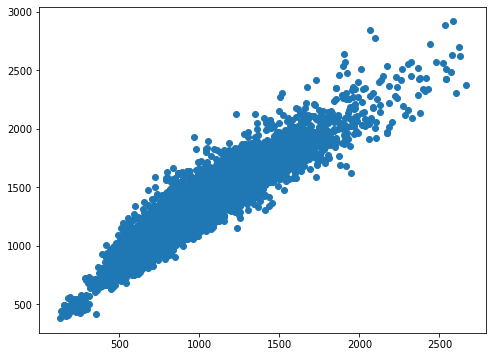

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(shapes_0, shapes_1)

##### Вот так выглядят наши данные 

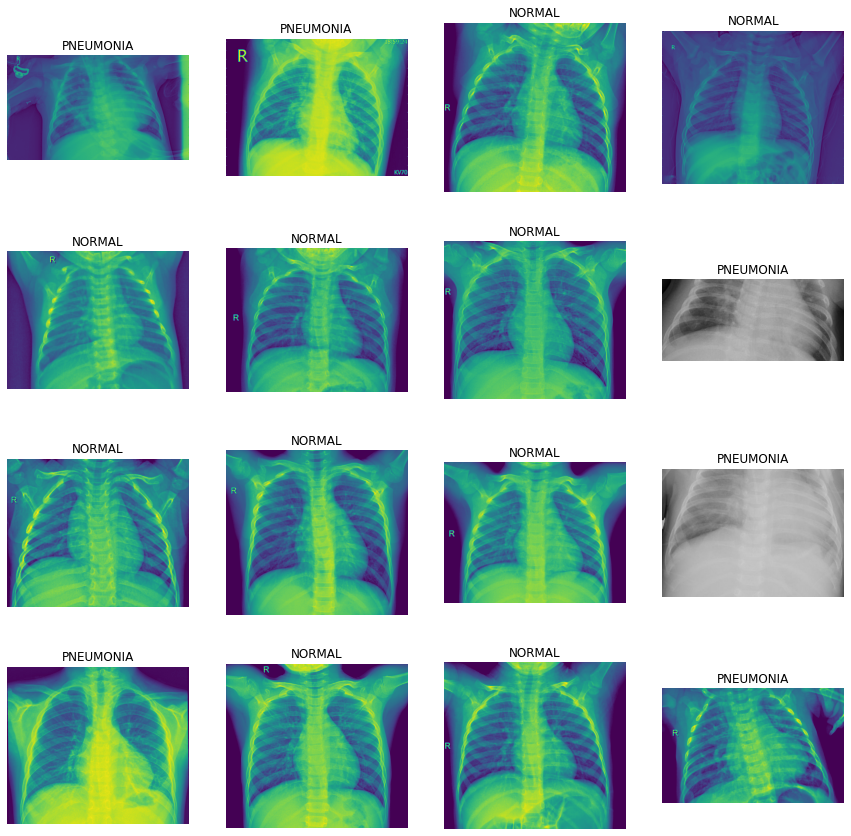

In [ ]:
plt.figure(figsize = (15,15))
for i in range(16) :
    plt.subplot(4,4,i + 1)
    n = int(np.random.random() *  5200)
    image = imread(train_df['path'][n])
    plt.imshow(image)
    plt.title(train_df['label'][n])
    plt.axis('off')
plt.show()

##### Подготавоиваем данные для валидации

In [ ]:
def give_set (data_frame):
    
    X = []
    y = []
    for item in data_frame.iterrows():
        image = keras.preprocessing.image.load_img(item[1]['path'], color_mode = 'grayscale', target_size = (128,128))
        X.append(keras.preprocessing.image.img_to_array(image))
        y.append(1 if item[1]['label'] == 'PNEUMONIA' else 0)
    X = np.array(X, dtype = float)
    y = np.array(y)

    return X, y

In [ ]:
X_train, y_train = give_set(train_df)
X_val, y_val = give_set(val_df)
X_test, y_test = give_set(test_df)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(5216, 128, 128, 1)
(5216,)


##### Посмотрим на распределение классов в исходных данных

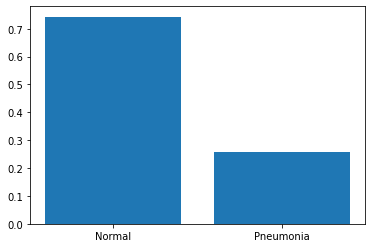

In [ ]:
index = ['Normal', 'Pneumonia']
plt.bar(index, [np.mean(train_df['label']=='PNEUMONIA'), np.mean(train_df['label']=='NORMAL')])
plt.show()

#### Создадим новые изображения, поскольку данные сильно смещены в сторону положительного класса


In [ ]:
# дополним наши данные
from imblearn.over_sampling import SMOTE

X_train = X_train.reshape(5216, 128*128)
X_train, y_train = SMOTE(sampling_strategy = 'auto', k_neighbors = 5, random_state = 1).fit_resample(X_train, y_train)
X_train = X_train.reshape(7750, 128, 128, 1)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train.shape

(7750, 128, 128, 1)

In [ ]:
y_train.shape

(7750,)

In [ ]:
# С имещимися изображениями проделаем преобразования, повернем, увеличим, отмасштабируем, отразим
train_data_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    shear_range=0.2)

train_data_gen.fit(X_val)

train_data = train_data_gen.flow(X_train, y_train,
                                 batch_size=32,
                                 shuffle=True)


##### А так они выглядят после обработки

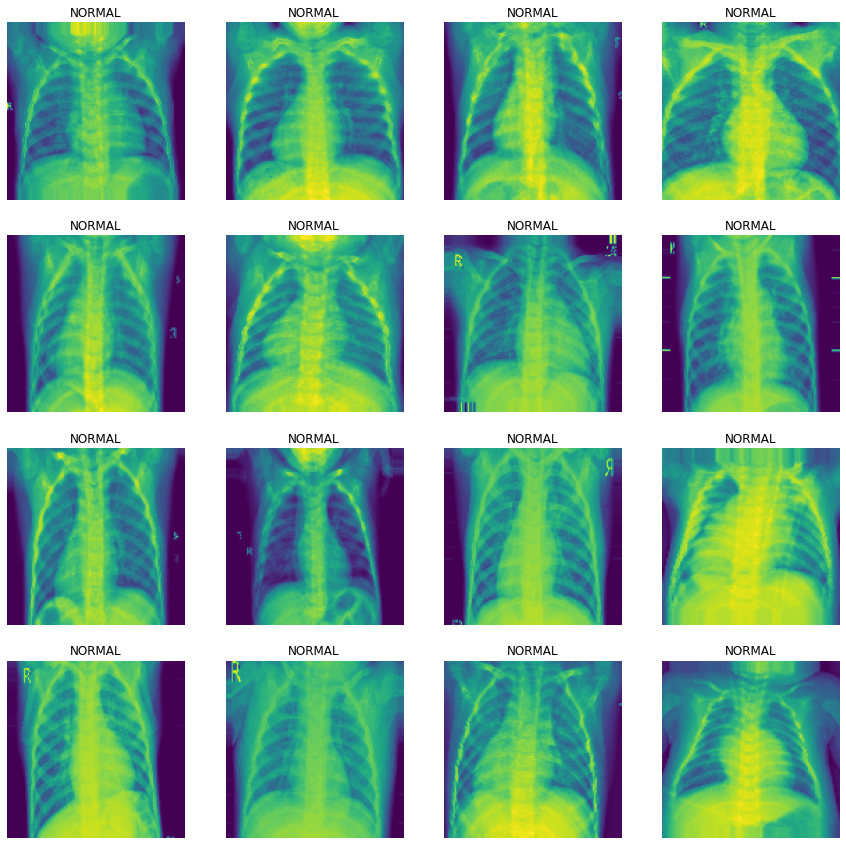

In [ ]:
plt.figure(figsize = (15,15))

for i in range(16) :
    plt.subplot(4,4,i+1)
    plt.imshow(train_data.next()[0][i].reshape(128, 128))
    plt.title(train_df['label'][i])
    plt.axis('off')
plt.show()

##### И посмотрим на распределение классов

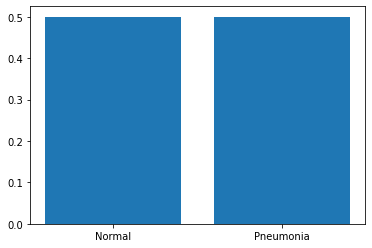

In [ ]:
index = ['Normal', 'Pneumonia']
plt.bar(index, [np.mean(y_train==1), np.mean(y_train==0)])
plt.show()

### Создадим модель

In [ ]:
def cnn (num_filters_1, num_filters_2, num_filters_3, hidden_nodes) :
    
    # create the cnn  model
    model = keras.models.Sequential()
    model.add(keras.Input(shape = (128, 128, 1, )))
    
    # 1st convolution layer
    model.add(keras.layers.Conv2D(num_filters_1, (3,3), padding = 'valid', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D((2,2), padding = 'valid'))
    
    # 2nd convolution layer
    model.add(keras.layers.Conv2D(num_filters_2, (3,3), padding = 'valid', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D((2,2), padding = 'valid'))
    
    # 3rd convolution layer
    model.add(keras.layers.Conv2D(num_filters_3, (3,3), padding = 'valid', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.MaxPooling2D((2,2), padding = 'valid'))
    
    # flatten and hidden layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hidden_nodes, kernel_regularizer =  'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.2))
    
    # output layer
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model


#### Подберем оптимальные гиперпараметры

In [ ]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn = cnn, verbose = 1)

In [ ]:
param = {'num_filters_1' : [128,200], 'num_filters_2' : [32,64],
         'num_filters_3' : [16 , 64], 'hidden_nodes'  : [32, 64]}
grd = RandomizedSearchCV(estimator = model, param_distributions = param, cv = KFold(n_splits = 3, shuffle = True, random_state = 1), verbose = 1)

In [ ]:
search = grd.fit(X_val, y_val, epochs = 5, batch_size = 32, verbose = 0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1/1 [==============================] - 0s 178ms/step - loss: 92.2878 - accuracy: 0.2000


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   43.1s finished


In [ ]:
print(search.best_params_)

{'num_filters_3': 16, 'num_filters_2': 32, 'num_filters_1': 128, 'hidden_nodes': 64}


### Обучим модель

In [ ]:
model = cnn(128, 32 , 16, 64)
print(model.summary())

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_387 (Conv2D)          (None, 126, 126, 128)     1280      
_________________________________________________________________
batch_normalization_516 (Bat (None, 126, 126, 128)     512       
_________________________________________________________________
activation_516 (Activation)  (None, 126, 126, 128)     0         
_________________________________________________________________
dropout_516 (Dropout)        (None, 126, 126, 128)     0         
_________________________________________________________________
max_pooling2d_387 (MaxPoolin (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_388 (Conv2D)          (None, 61, 61, 32)        36896     
_________________________________________________________________
batch_normalization_517 (Bat (None, 61, 61, 32)     

In [ ]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Сохраняем веса каждые 5 эпохи.
    period=5)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience  = 10)

In [ ]:
hist = model.fit(train_data, epochs=150, callbacks=[cp_callback, reduce], verbose=1, validation_data=(X_val, y_val))

Epoch 1/150
243/243 [==============================] - 12s 47ms/step - loss: 1.5662 - accuracy: 0.8894 - val_loss: 113.6974 - val_accuracy: 0.5000
Epoch 2/150
243/243 [==============================] - 11s 46ms/step - loss: 0.4876 - accuracy: 0.9208 - val_loss: 139.5264 - val_accuracy: 0.5000
Epoch 3/150
243/243 [==============================] - 11s 46ms/step - loss: 0.3674 - accuracy: 0.9200 - val_loss: 433.6835 - val_accuracy: 0.5000
Epoch 4/150
243/243 [==============================] - 11s 46ms/step - loss: 0.3402 - accuracy: 0.9290 - val_loss: 93.9572 - val_accuracy: 0.5625
Epoch 5/150
243/243 [==============================] - 11s 46ms/step - loss: 0.3321 - accuracy: 0.9289 - val_loss: 332.9788 - val_accuracy: 0.5000

Epoch 00005: saving model to training_2/cp-0005.ckpt
Epoch 6/150
243/243 [==============================] - 11s 45ms/step - loss: 0.2993 - accuracy: 0.9383 - val_loss: 264.6686 - val_accuracy: 0.5625
Epoch 7/150
243/243 [==============================] - 11s 46ms/s

##### Посмотрим на эволюцию в процессе обучения

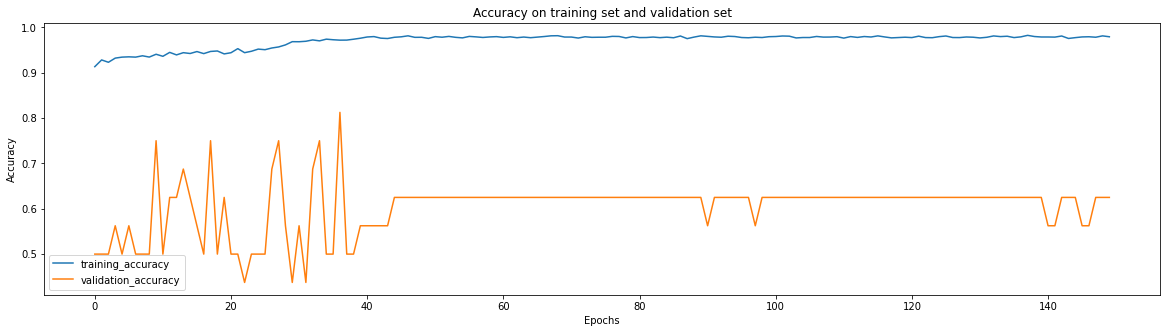

In [ ]:
fig = plt.figure(figsize = (20,5))
plt.plot(hist.history['accuracy'])                  
plt.plot(hist.history['val_accuracy'])               
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

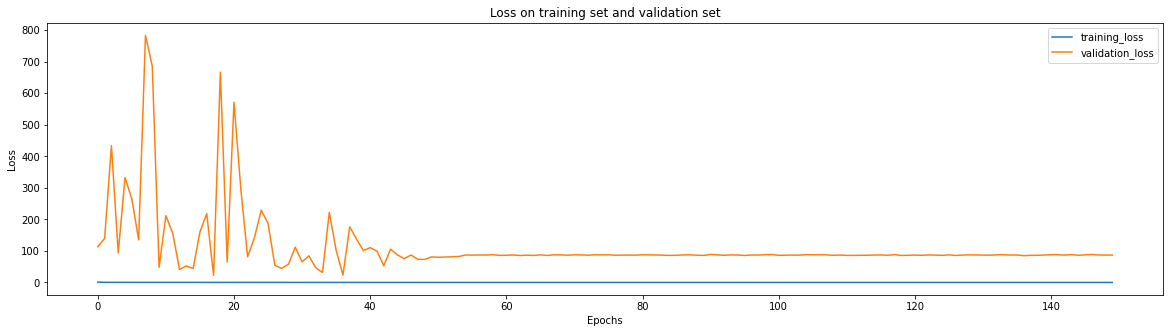

In [ ]:
fig = plt.figure(figsize = (20,5))
plt.plot(hist.history['loss'])                  
plt.plot(hist.history['val_loss'])               
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# на случай, если что-то пошло не так
checkpoints = Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])

model = cnn(135, 60, 35, 35)
model.load_weights(latest)
# количество эпох здесь выбираем вручную, в зависимости от то того сколько мы уже отучились
hist = model.fit(train_data, epochs = 3, validation_data = (X_val, y_val), verbose=1, callbacks=[cp_callback])

In [ ]:
# Сохраним модель 
json_file = 'model.json'
model_json = model.to_json()

with open(json_file, 'w') as f:
  f.write(model_json)

### Оценка качества модели

In [ ]:
# получим путь к файлу с последними весами
checkpoints = Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])


In [ ]:
model = cnn(128, 32, 16, 64)
model.load_weights(latest)

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Restored model, accuracy: {}%".format(100*acc))

20/20 [==============================] - 0s 9ms/step - loss: 23.4958 - accuracy: 0.8077
Restored model, accuracy: 80.7692289352417%


#### Как итог получили точность нашей модели 80.76 %.